In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import os
import sys
import torch

import os
import sys

import shutil
import matplotlib.pyplot as plt

In [ ]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "./"))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging
from src.poisson.dv_solver import DVPDESolver
from src.poisson.cv_solver import CVPDESolver
from src.nn.pde import wave_operator
from src.utils.plot_prediction import plt_prediction
from src.data.klein_gordon_dataset import u, f
import src.poisson.klein_gordon_train as klein_gordon_train
from src.poisson.classical_solver import Classical_Solver
from src.data.klein_gordon_dataset import Sampler

from src.nn.pde import klein_gordon_operator

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'    # for no GPUs


In [ ]:
log_path = "./testing_checkpoints"
logger = Logging(log_path)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

## Generate Testing Dataset


In [ ]:
# Parameters of equations
alpha = torch.tensor(-1.0, device=DEVICE)
beta = torch.tensor(0.0, device=DEVICE)
gamma = torch.tensor(1.0, device=DEVICE)
k = 3
dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]], dtype=np.float32)


# Create mesh grid with float32
nn = 10
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn, dtype=np.float32)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn, dtype=np.float32)[:, None]
t, x = np.meshgrid(t, x)

# Convert to PyTorch tensor with float32
X_star = torch.hstack((
    torch.from_numpy(t.flatten()[:, None]), 
    torch.from_numpy(x.flatten()[:, None])
)).to(DEVICE).to(torch.float32)

u_star = u(X_star)
f_star = f(X_star, alpha, beta, gamma, k)

# Load trained model


In [ ]:
model_path = (
    "./models/2025-02-21_11-44-19-583365"  # circ_19
)

In [ ]:
data = X_star
solver = "DV"

if solver == "CV":
    state = CVPDESolver.load_state(os.path.join(model_path, "model.pth"))
    model = CVPDESolver(state["args"], logger, data, DEVICE)

    model.preprocessor.load_state_dict(state["preprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])
    model.postprocessor.load_state_dict(state["postprocessor"])
else:
    state = DVPDESolver.load_state(os.path.join(model_path, "model.pth"))
    model = DVPDESolver(state["args"], logger, data, DEVICE)
    model.preprocessor.load_state_dict(state["preprocessor"])
    model.postprocessor.load_state_dict(state["postprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])


model.logger = logger
model.logger.print(f"The settings used: {model.args}")
for key, value in model.args.items():
    model.logger.print(f"{key} : {value}")

model.logger.print(f"Totoal number of iterations : {len(state['loss_history'])}")
model.logger.print(f"The final loss : {state['loss_history'][-1]}")

model.loss_history = state["loss_history"]
model.model_path = logger.get_output_dir()


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")
shutil.copytree(model_path, os.path.join(logger.get_output_dir(), model_path.split('/')[-1]), dirs_exist_ok=True)


In [ ]:
n = 100  # Number of last iterations to plot
plt.plot(range(len(model.loss_history[-n:])), model.loss_history[-n:])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

In [ ]:
# Predictions


u_pred_star, f_pred_star = klein_gordon_operator(model, X_star[:, 0:1], X_star[:, 1:2])

u_pred = u_pred_star.cpu().detach().numpy()
f_pred = f_pred_star.cpu().detach().numpy()
u_star = u_star.cpu().detach().numpy()
f_star = f_star.cpu().detach().numpy()
X = X_star.cpu().detach().numpy()

In [ ]:
# Relative L2 error
error_u = np.linalg.norm(u_pred - u_star) / np.linalg.norm(u_star) * 100
error_f = np.linalg.norm(f_pred - f_star) / np.linalg.norm(f_star) * 100
logger.print("Relative L2 error_u: {:.2e}".format(error_u))
logger.print("Relative L2 error_f: {:.2e}".format(error_f))


# Plot predictions
plt_prediction(
    logger,
    X,
    u_star,
    u_pred,
    f_star,
    f_pred,
)


### OR Simply call the python script
```bash
python -m src.contour_plots.klein_gordon_hybrid_plotting
```

INFO:src.utils.logger:checkpoint path: self.log_path='testing_checkpoints/klein_gordon/2025-03-03_22-20-48-604713'
INFO:src.utils.logger:Using classical Solver
INFO:src.utils.logger:Total number of iterations : 20001
INFO:src.utils.logger:The final loss : 0.7182420492172241
INFO:src.utils.logger:Relative L2 error_u: 1.75e+01
INFO:src.utils.logger:Relative L2 error_f: 3.35e+00
INFO:src.utils.logger:Total number of parameters: 7851


INFO:src.utils.logger:Using DV Solver
INFO:src.utils.logger:Total number of iterations : 20001
INFO:src.utils.logger:The final loss : 0.4958180785179138
INFO:src.utils.logger:The circuit used in the study:


Model state loaded from /okyanus/users/afarea/afrah/code/QNN4PDEs/log_files/checkpoints/klein_gordon/2025-02-25_17-01-13-323053/model.pth
Model state loaded from /okyanus/users/afarea/afrah/code/QNN4PDEs/log_files/checkpoints/klein_gordon/2025-02-21_11-44-19-583365/model.pth
The circuit is saved in testing_checkpoints/klein_gordon/2025-03-03_22-20-48-604713


INFO:src.utils.logger:Relative L2 error_u: 1.20e+01
INFO:src.utils.logger:Relative L2 error_f: 2.58e+00
INFO:src.utils.logger:Total number of parameters: 771


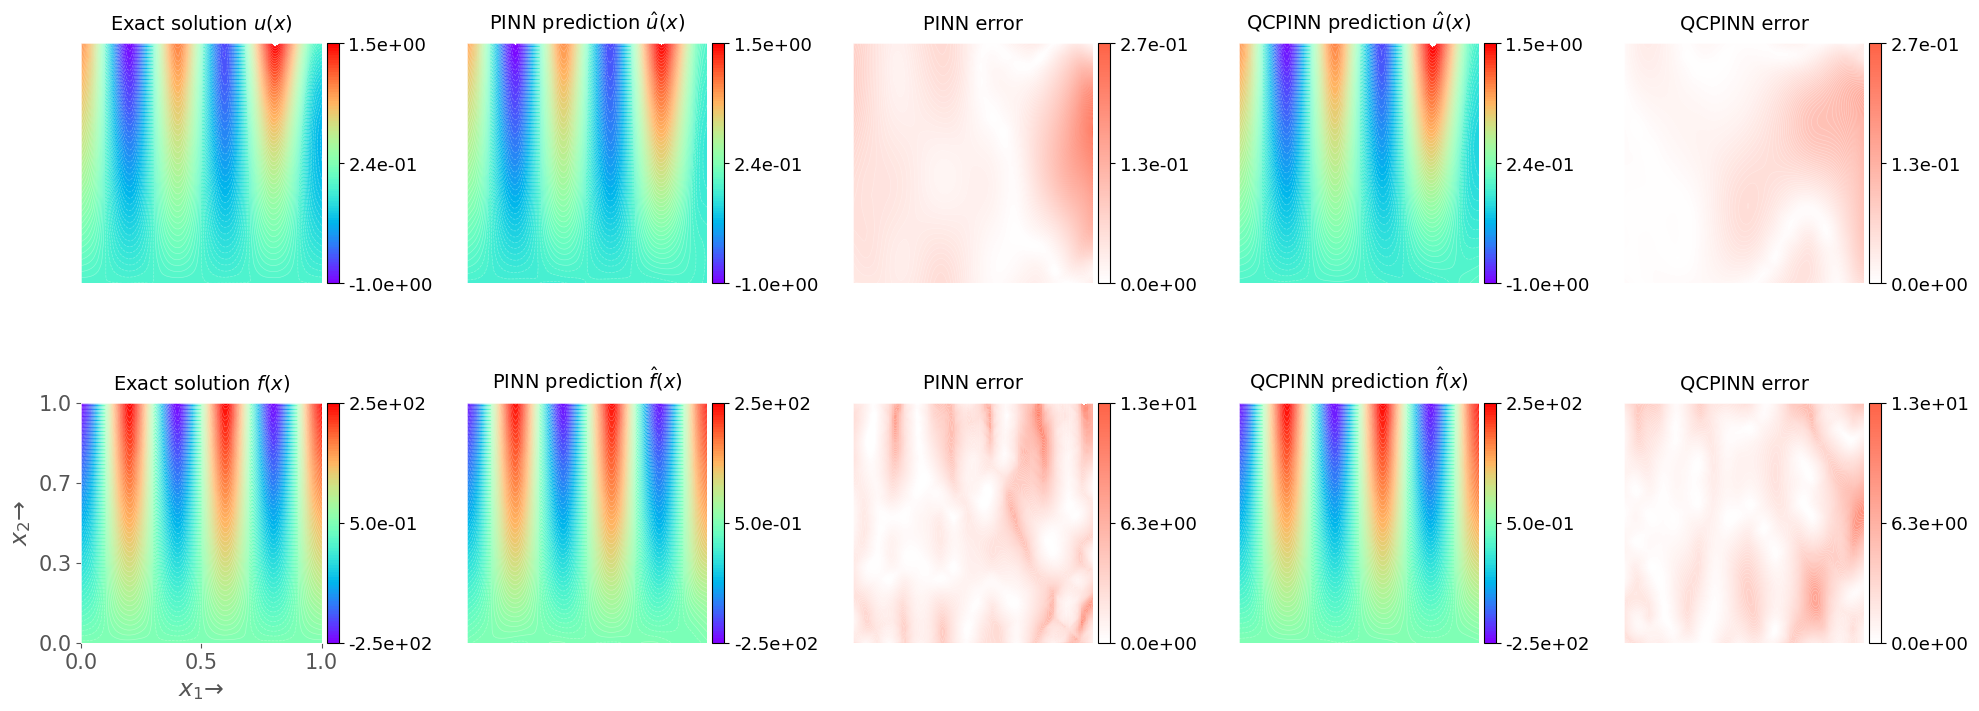


Loss values at iteration 12500:
----------------------------------------
classical           : 0.869454
angle_cascade       : 0.321913
----------------------------------------


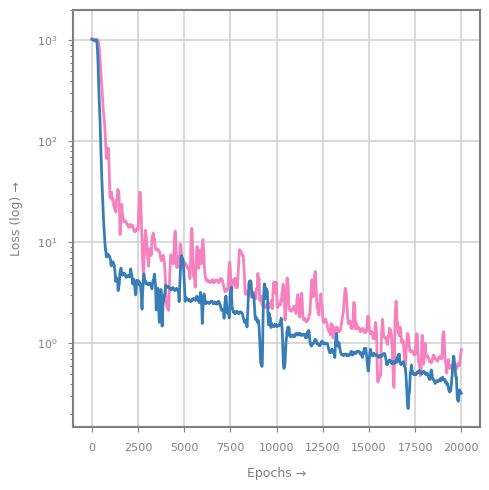

In [3]:
run -m src.contour_plots.klein_gordon_hybrid_plotting